In [ ]:
# Add this at the beginning of your code (before dataset initialization)
import os
import requests
import zipfile

def download_div2k():
    os.makedirs("/content/DIV2K", exist_ok=True)

    # Download DIV2K train dataset (HR images)
    if not os.path.exists("/content/DIV2K/DIV2K_train_HR"):
        print("Downloading DIV2K dataset...")
        url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
        r = requests.get(url, stream=True)
        with open("/content/DIV2K/train_hr.zip", "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

        print("Extracting...")
        with zipfile.ZipFile("/content/DIV2K/train_hr.zip", 'r') as zip_ref:
            zip_ref.extractall("/content/DIV2K")
        os.remove("/content/DIV2K/train_hr.zip")

    # Download DIV2K validation dataset (HR images)
    if not os.path.exists("/content/DIV2K/DIV2K_valid_HR"):
        print("Downloading DIV2K validation set...")
        url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
        r = requests.get(url, stream=True)
        with open("/content/DIV2K/valid_hr.zip", "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

        print("Extracting...")
        with zipfile.ZipFile("/content/DIV2K/valid_hr.zip", 'r') as zip_ref:
            zip_ref.extractall("/content/DIV2K")
        os.remove("/content/DIV2K/valid_hr.zip")

# Download the dataset before creating the dataset object
download_div2k()

Extracting...
Extracting...


Epoch 1/5: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


Epoch 1: Avg Loss = 0.2020


Epoch 2/5: 100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Epoch 2: Avg Loss = 0.1061


Epoch 3/5: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Epoch 3: Avg Loss = 0.0942


Epoch 4/5: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


Epoch 4: Avg Loss = 0.0901


Epoch 5/5: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Epoch 5: Avg Loss = 0.0837
Model saved to: /content/real_esrgan_div2k.pth
PSNR: 22.75 dB
SSIM: 0.6859


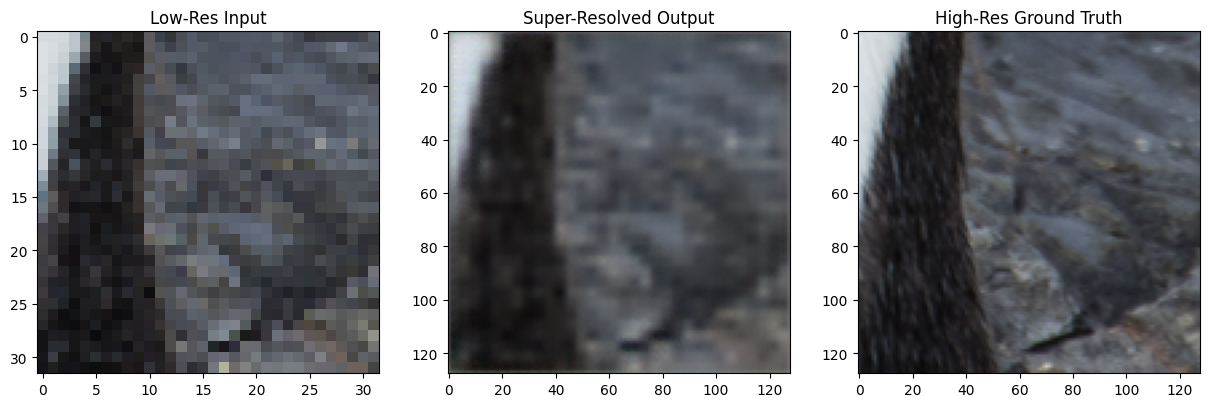

In [ ]:
# 1. Import Libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# 2. Dataset Loader (DIV2K)
class DIV2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4, train=True):
        self.hr_path = "/content/DIV2K/DIV2K_train_HR" if train else "/content/DIV2K/DIV2K_valid_HR"
        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.hr_path, self.image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()
        return {'lr': lr_img, 'hr': hr_img}

# 3. Model Definition (Simplified Real-ESRGAN)
class ResidualDenseBlock(nn.Module):
    def __init__(self, channels=64, growth_channels=32):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(channels, growth_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(growth_channels, growth_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(growth_channels, growth_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(growth_channels, channels, 3, 1, 1)
        )
    def forward(self, x):
        return x + self.layers(x) * 0.2

class RRDB(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(channels)
        self.rdb2 = ResidualDenseBlock(channels)
        self.rdb3 = ResidualDenseBlock(channels)
    def forward(self, x):
        return x + self.rdb3(self.rdb2(self.rdb1(x))) * 0.2

class RealESRGAN(nn.Module):
    def __init__(self, scale=4, num_rrdb=5):
        super().__init__()
        self.conv_first = nn.Conv2d(3, 64, 3, 1, 1)
        self.trunk = nn.Sequential(*[RRDB() for _ in range(num_rrdb)])
        self.trunk_conv = nn.Conv2d(64, 64, 3, 1, 1)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, True),
        ) if scale == 4 else nn.Identity()
        self.final = nn.Conv2d(64, 3, 3, 1, 1)
    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.trunk(fea))
        out = fea + trunk
        out = self.upsample(out)
        return self.final(out)

# 4. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = DIV2KDataset(train=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = RealESRGAN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5  # You can change this
save_path = "/content/real_esrgan_div2k.pth"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# 5. Save Model
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

# 6. Load Model
model.load_state_dict(torch.load(save_path))
model.eval()

# 7. Evaluation Metrics: PSNR & SSIM
def evaluate_metrics(model, dataset, num_samples=5):
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            lr = sample['lr'].unsqueeze(0).to(device)
            hr = sample['hr'].permute(1, 2, 0).numpy()
            sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

            hr = ((hr + 1) * 127.5).astype(np.uint8)
            sr = ((sr + 1) * 127.5).astype(np.uint8)

            psnr_val = psnr_metric(hr, sr, data_range=255)
            ssim_val = ssim_metric(hr, sr, channel_axis=-1)

            psnr_vals.append(psnr_val)
            ssim_vals.append(ssim_val)

    print(f"PSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"SSIM: {np.mean(ssim_vals):.4f}")

# Evaluate on validation set
val_dataset = DIV2KDataset(train=False)
evaluate_metrics(model, val_dataset, num_samples=10)

# 8. Show Output
def show_sr_result(model, dataset, idx=0):
    with torch.no_grad():
        sample = dataset[idx]
        lr = sample['lr'].unsqueeze(0).to(device)
        sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()
        hr = sample['hr'].permute(1, 2, 0).numpy()
        lr = sample['lr'].permute(1, 2, 0).numpy()

        sr = (sr + 1) * 127.5
        hr = (hr + 1) * 127.5
        lr = (lr + 1) * 127.5

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(lr.astype(np.uint8))
        plt.title("Low-Res Input")
        plt.subplot(1, 3, 2)
        plt.imshow(sr.astype(np.uint8))
        plt.title("Super-Resolved Output")
        plt.subplot(1, 3, 3)
        plt.imshow(hr.astype(np.uint8))
        plt.title("High-Res Ground Truth")
        plt.show()

show_sr_result(model, val_dataset, idx=0)